## This is an example of the Survival Concept-based Bottleneck Model usage

Let's start with the survival regression task. We will generate data based on the MNIST dataset and Weibull distribution.

In [1]:
from pkg.datasets import get_4mnist_ds, get_proc_mnist_np
from pkg.utility import get_str_array
from sklearn.model_selection import train_test_split
import numpy as np

n = 3000
uncens_part = 0.33
l = 1e-3
nu = 10
seed = None
b = -10 * np.asarray([0] * 10 + [1, 1] + [0] * 8 + [1, 1, 1] + [0] * 7 + [1, 1, 1, 1] + [0] * 6)
X, t, d, c = get_4mnist_ds(*get_proc_mnist_np(), n, uncens_part, l, nu, b,
                           seed, f_use_one_hot=True)
y = get_str_array(t, d)
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=0.4)
X_train, X_val, y_train, y_val, c_train, c_val = train_test_split(X_train, y_train, c_train,
                                                                  test_size=0.33)
train_set = (X_train, y_train, c_train)
val_set = (X_val, y_val, c_val)

We can look at the time distribution we have just generated

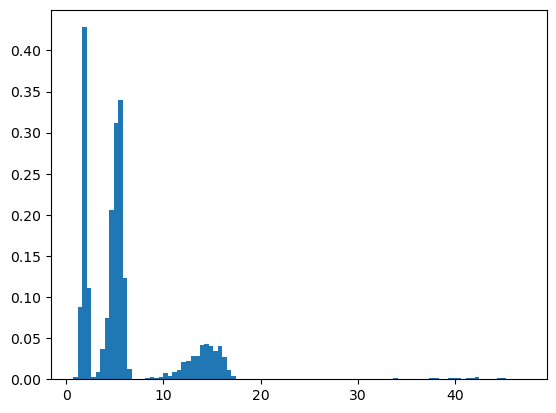

In [2]:
import matplotlib.pyplot as plt

_ = plt.hist(t, 100, density=True)

And an example of the data point

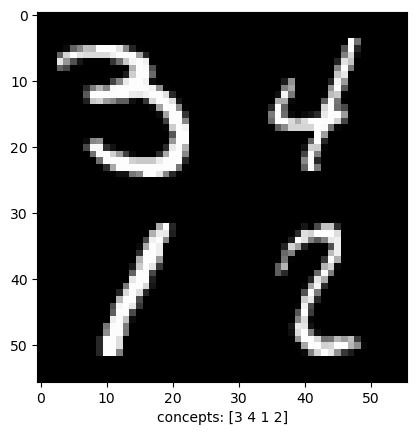

In [3]:
plt.imshow(X[0, 0], 'grey')
plt.xlabel('concepts: ' + str(c[0]));

Now let's import the Survival Bottleneck model and train it on the data. We will use Beran estimator as the survival estimator.

In [4]:
import torch
from pkg.model import SurvBN
from sklearn.metrics import accuracy_score

params = {
    'surv_model': 'beran',
    'surv_loss': 'c_index',
    'beran_metric': 'l2',
    'sigma_temp': 1,
    'alpha': 0.8,
    'batch_num': 64,
    'train_bg_part': 0.5,
    'nn_model': torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, (16, 16), stride=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 16, (8, 8), stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 32, (6, 6), stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, (4, 4), stride=1),
            torch.nn.LeakyReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(288, 256),
        ),
    'nn_model_out_dim': 256,
    'device': 'mps',
    'epochs': 3,
    'patience': 3,
    'optimizer': 'AdamW',
    'optimizer_kw': {'lr': 1e-3, 'weight_decay': 1e-3},
}
model = SurvBN(**params)
model.fit(*train_set, val_set);

Epoch 1: 100%|##########| 64/64 [00:29<00:00,  2.18task/s, Loss=0.339, Surv=0.67, CE=[1.0109375, 1.1523437499999998, 1.0390625000000002, 1.1789062499999998]]          


Val C-index: 0.75043, patience: 0


Epoch 2: 100%|##########| 64/64 [00:29<00:00,  2.14task/s, Loss=-0.488, Surv=0.763, CE=[0.12343749999999976, 0.1531250000000001, 0.14921875, 0.15937500000000002]]          


Val C-index: 0.75231, patience: 0


Epoch 3: 100%|##########| 64/64 [00:30<00:00,  2.08task/s, Loss=-0.596, Surv=0.775, CE=[0.012500000000000002, 0.011718750000000002, 0.028906250000000012, 0.020312500000000008]]


Val C-index: 0.75309, patience: 0
Training time: 92.1 s.


Let's estimate metrics for our model. Take in account that we were using not many epochs and didn't select parameters for the example's clarity.

In [5]:
print('C-index of the model:', model.score(X_test, y_test))
_, c_probas = model.predict(X_test)
c_labels_list = []
for i, c in enumerate(c_probas):
    c_labels_cur = np.argmax(c, axis=-1)
    print(f'Accuracy for concept {i}:', accuracy_score(c_test[:, i], c_labels_cur))
    c_labels_list.append(c_labels_cur)
c_labels = np.stack(c_labels_list, axis=-1)

C-index of the model: 0.7669633179013909
Accuracy for concept 0: 0.8958333333333334
Accuracy for concept 1: 0.8791666666666667
Accuracy for concept 2: 0.8041666666666667
Accuracy for concept 3: 0.8775


Now let's explain some prediction using the Survival Bottleneck and Beran estimator.

In [6]:
# helper functions

def swap_ch(img):
    return img.swapaxes(0, 1).swapaxes(1, 2)

def draw_importance(X, C, I, cards, b_mask, cmap):
    def get_formatted_labels(labels, imp_mask):
        str_list = []
        for i in range(len(labels)):
            if imp_mask[i]:
                str_list.append(rf"$\bf{{{labels[i]}}}$")
            else:
                str_list.append(f"{labels[i]}")
        return "[" + ",".join(str_list) + "]"
        
    C_oh = np.zeros(np.sum(cards))
    counter = 0
    for i, c in enumerate(cards):
        E = np.eye(c, dtype=np.int64)
        C_oh[counter: counter + c] = E[C[i]]
        counter += c
    f_important_mask = C_oh * b_mask
    counter = 0
    imp_final_mask = np.zeros(len(cards), dtype=bool)
    for i, c in enumerate(cards):
        imp_final_mask[i] = np.sum(f_important_mask[counter:counter + c]) > 0
        counter += c

    per_subplot_kw = { 
        'original': {
            'frame_on': False,
            'xticks': [],
            'yticks': [],
            'title': 'Example',
            'xlabel': get_formatted_labels(C, imp_final_mask),
        },
        'importance': {
            'title': 'Concepts importance',
            'ylabel': 'Importance score',
        }
    }
    fig, axes = plt.subplot_mosaic([['.', '.'], ['original', 'importance'], ['.', '.']], per_subplot_kw=per_subplot_kw, figsize=(10, 10), dpi=150,
                                  width_ratios=[1, 2], height_ratios=[1, 1, 1])
    axes['original'].imshow(swap_ch(X), cmap=cmap)
    axes['importance'].bar([f'$c_{i}$' for i in range(1, I.shape[0] + 1)], I, zorder=100)
    axes['importance'].grid(zorder=-100)
    fig.set_layout_engine('tight')

The important outcome (according to the vector `b` of the Weibull distribution parameters) is marked as bold under the picture.

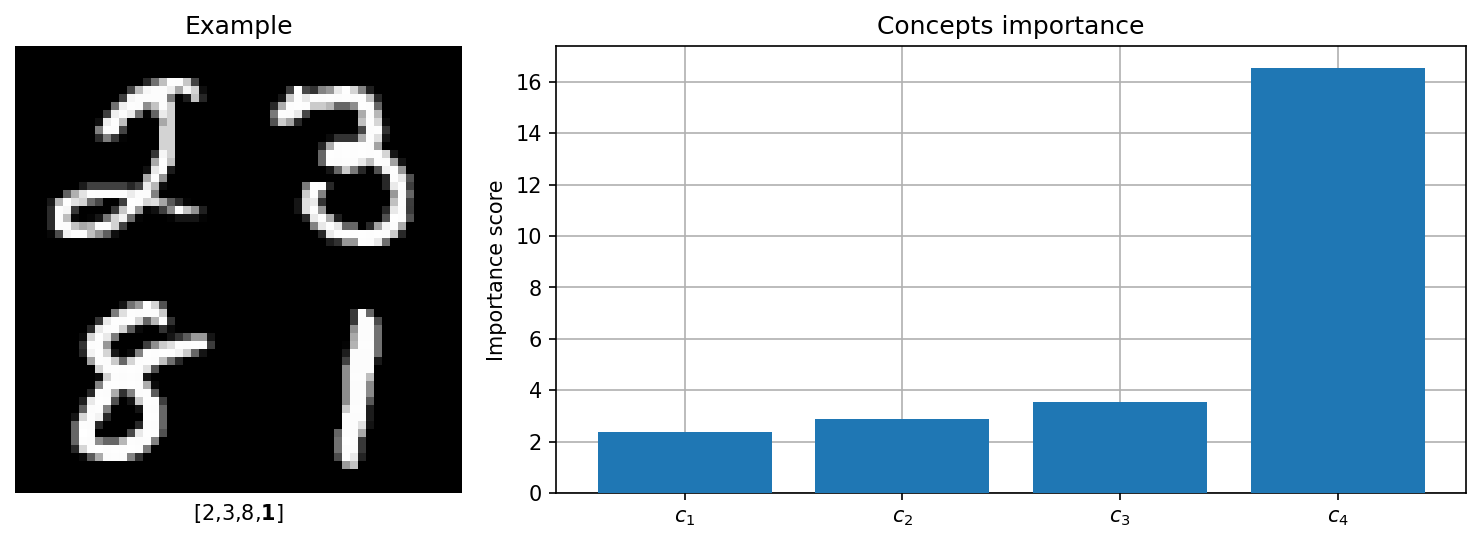

In [7]:
importance = model.get_importance(X_test, top_k=40)
cmap = 'grey'
test_id = 0
draw_importance(X_test[test_id],
                c_labels[test_id],
                importance[test_id],
                model.c_cards,
                b < 0,
                cmap)

Now let's do the same using the Cox estimator.

In [8]:
params = {
    'surv_model': 'cox',
    'surv_loss': 'likelihood',
    'alpha': 0.2,
    'batch_num': 64,
    'cox_base': 'breslow',
    'cox_logits': False,
    'cox_bias': False,
    'nn_model': torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, (16, 16), stride=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 16, (8, 8), stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 32, (6, 6), stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, (4, 4), stride=1),
            torch.nn.LeakyReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(288, 256),
        ),
    'nn_model_out_dim': 256,
    'device': 'mps',
    'epochs': 20,
    'patience': 10,
    'optimizer': 'AdamW',
    'optimizer_kw': {'lr': 1e-3, 'weight_decay': 0},
}
model = SurvBN(**params)
model.fit(*train_set, val_set);

Epoch 1: 100%|##########| 19/19 [00:01<00:00, 16.84task/s, Loss=28.6, Surv=-107, CE=[2.210526315789474, 2.257894736842106, 2.3, 2.2526315789473688]]                


Val C-index: 0.59591, patience: 0


Epoch 2: 100%|##########| 19/19 [00:00<00:00, 20.72task/s, Loss=25.7, Surv=-106, CE=[1.1421052631578943, 1.4631578947368422, 1.6000000000000003, 1.5105263157894737]]


Val C-index: 0.64546, patience: 0


Epoch 3: 100%|##########| 19/19 [00:00<00:00, 20.88task/s, Loss=23.9, Surv=-105, CE=[0.6473684210526316, 0.9736842105263158, 0.8947368421052632, 0.994736842105263]] 


Val C-index: 0.68066, patience: 0


Epoch 4: 100%|##########| 19/19 [00:00<00:00, 20.89task/s, Loss=22.9, Surv=-105, CE=[0.46315789473684205, 0.7105263157894737, 0.6210526315789472, 0.7105263157894737]]


Val C-index: 0.68699, patience: 0


Epoch 5: 100%|##########| 19/19 [00:00<00:00, 21.43task/s, Loss=22.3, Surv=-103, CE=[0.38421052631578945, 0.5736842105263157, 0.5368421052631579, 0.5631578947368422]]


Val C-index: 0.70708, patience: 0


Epoch 6: 100%|##########| 19/19 [00:00<00:00, 20.42task/s, Loss=21.7, Surv=-102, CE=[0.28421052631578947, 0.37894736842105264, 0.3947368421052631, 0.431578947368421]]   


Val C-index: 0.72732, patience: 0


Epoch 7: 100%|##########| 19/19 [00:00<00:00, 20.84task/s, Loss=21.4, Surv=-102, CE=[0.2947368421052631, 0.30526315789473685, 0.3315789473684211, 0.34736842105263166]] 


Val C-index: 0.7305, patience: 0


Epoch 8: 100%|##########| 19/19 [00:00<00:00, 21.73task/s, Loss=21.2, Surv=-101, CE=[0.24736842105263154, 0.2578947368421053, 0.30526315789473685, 0.3842105263157895]]


Val C-index: 0.7456, patience: 0


Epoch 9: 100%|##########| 19/19 [00:00<00:00, 21.72task/s, Loss=20.9, Surv=-101, CE=[0.1789473684210527, 0.2315789473684211, 0.2473684210526316, 0.3263157894736842]]   


Val C-index: 0.75334, patience: 0


Epoch 10: 100%|##########| 19/19 [00:00<00:00, 21.24task/s, Loss=20.6, Surv=-100, CE=[0.1578947368421053, 0.1789473684210527, 0.21578947368421056, 0.20526315789473687]]   


Val C-index: 0.76152, patience: 0


Epoch 11: 100%|##########| 19/19 [00:00<00:00, 21.55task/s, Loss=20.5, Surv=-99.5, CE=[0.16315789473684217, 0.14210526315789476, 0.20526315789473687, 0.25263157894736843]]


Val C-index: 0.7685, patience: 0


Epoch 12: 100%|##########| 19/19 [00:00<00:00, 21.44task/s, Loss=20.3, Surv=-99, CE=[0.06842105263157895, 0.12631578947368424, 0.16315789473684217, 0.21578947368421056]]  


Val C-index: 0.77429, patience: 0


Epoch 13: 100%|##########| 19/19 [00:00<00:00, 21.19task/s, Loss=20, Surv=-97.7, CE=[0.08947368421052633, 0.08947368421052633, 0.14736842105263157, 0.2000000000000001]]   


Val C-index: 0.77213, patience: 1


Epoch 14: 100%|##########| 19/19 [00:00<00:00, 21.78task/s, Loss=19.9, Surv=-97.4, CE=[0.09473684210526316, 0.11052631578947371, 0.1578947368421053, 0.18947368421052638]] 


Val C-index: 0.78237, patience: 0


Epoch 15: 100%|##########| 19/19 [00:00<00:00, 21.70task/s, Loss=19.8, Surv=-97.5, CE=[0.0736842105263158, 0.08947368421052636, 0.12105263157894738, 0.13684210526315796]]


Val C-index: 0.78471, patience: 0


Epoch 16: 100%|##########| 19/19 [00:00<00:00, 21.75task/s, Loss=19.6, Surv=-96.2, CE=[0.07894736842105264, 0.07368421052631578, 0.1578947368421053, 0.14736842105263165]]


Val C-index: 0.78531, patience: 0


Epoch 17: 100%|##########| 19/19 [00:00<00:00, 20.92task/s, Loss=19.6, Surv=-96.1, CE=[0.06315789473684211, 0.12631578947368424, 0.16315789473684217, 0.13684210526315793]]


Val C-index: 0.77911, patience: 1


Epoch 18: 100%|##########| 19/19 [00:00<00:00, 21.72task/s, Loss=19.5, Surv=-95.6, CE=[0.0736842105263158, 0.12631578947368424, 0.11578947368421054, 0.12105263157894741]] 


Val C-index: 0.79032, patience: 0


Epoch 19: 100%|##########| 19/19 [00:00<00:00, 20.87task/s, Loss=19.4, Surv=-94.9, CE=[0.1, 0.08421052631578947, 0.1368421052631579, 0.18947368421052632]]                 


Val C-index: 0.78675, patience: 1


Epoch 20: 100%|##########| 19/19 [00:00<00:00, 20.90task/s, Loss=19.4, Surv=-94.9, CE=[0.0736842105263158, 0.05263157894736842, 0.1736842105263158, 0.2052631578947369]]    


Val C-index: 0.7826, patience: 2
Training time: 20.7 s.


In [9]:
print('C-index of the model:', model.score(X_test, y_test))
_, c_probas = model.predict(X_test)
c_labels_list = []
for i, c in enumerate(c_probas):
    c_labels_cur = np.argmax(c, axis=-1)
    print(f'Accuracy for concept {i}:', accuracy_score(c_test[:, i], c_labels_cur))
    c_labels_list.append(c_labels_cur)
c_labels = np.stack(c_labels_list, axis=-1)

C-index of the model: 0.7779902343156423
Accuracy for concept 0: 0.8933333333333333
Accuracy for concept 1: 0.8841666666666667
Accuracy for concept 2: 0.87
Accuracy for concept 3: 0.865


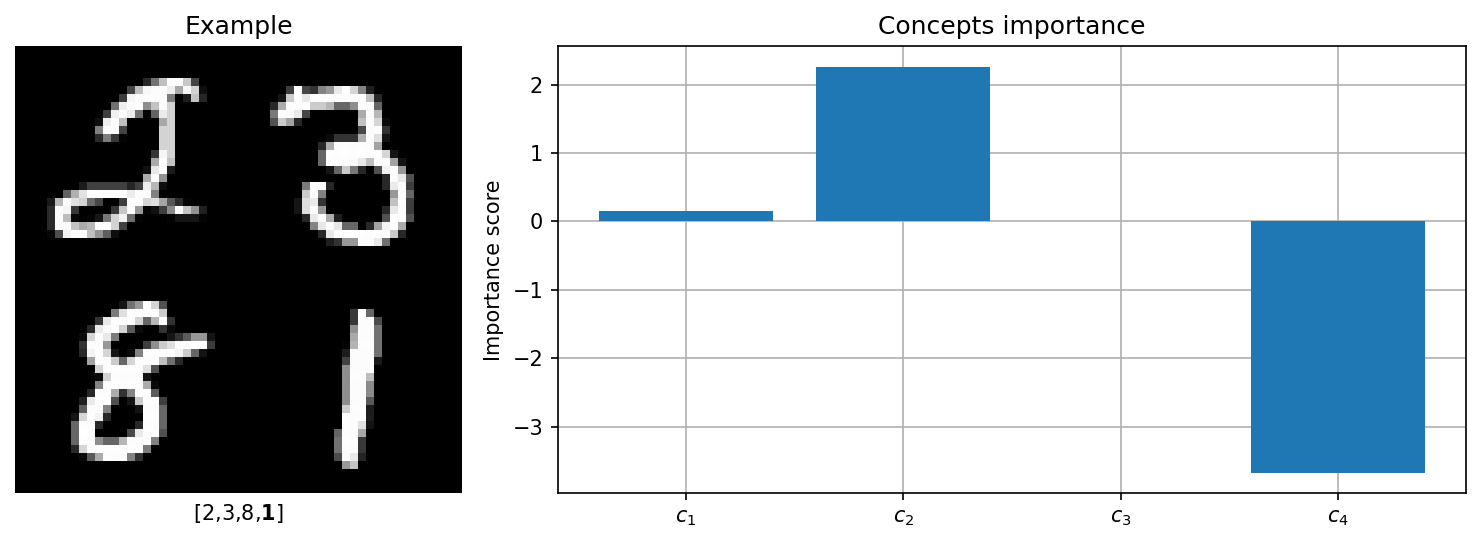

In [ ]:
importance = model.get_importance(X_test)
cmap = 'grey'
test_id = 0
draw_importance(X_test[test_id],
                c_labels[test_id],
                importance[test_id],
                model.c_cards,
                b < 0,
                cmap)

Another model, Survival Regularized Concept-based Model, has similar interface and is able to do only the survival regression task, without the explanation. 